In [1]:
import time
import cv2
import math

import numpy as np

from swarm import Swarm


In [2]:
NUM_DRONES = 5

AREA_SIZE_X = 50
AREA_SIZE_Y = 50
GRID_SIZE = 50           # Size of the Forest

CAMERA_FOV_DEGREE = 50
IMAGE_SIZE = 512 #How many Scanning points each image has per Row (Images are 512x512)

MOVE_DISTANCE = 1       # How far a Drone can move each Timestep
DRONE_HEIGHT = 35

TIMESTEPS = 10
POPULATION_SIZE = 10
NUM_GENERATIONS = 10
MUTATION_RATE = 0.1

INITIAL_VISIBILITY =0.5

In [3]:
grid_offset=GRID_SIZE/2

camera_fov=np.deg2rad(CAMERA_FOV_DEGREE)
camera_offset= 35 * np.tan(camera_fov/2)



In [30]:
#Create "Base Grid"
#by Calculating distance between each scanning point at DRONE_HEIGHT

#Gives Coordinates based on drone position and scan pixel
def calculate_world_coordinates(drone_pos, image_radius, img_x, img_y):
    pos_x = drone_pos[0] + (img_x-256)/512 * image_radius * 2
    pos_y = drone_pos[1] + (img_y-256)/512 * image_radius * 2
    return (pos_x, pos_y)
#print(calculate_world_coordinates(np.array([0.5,-0.46815]),camera_offset,0,512))

def getOverlapArray(waypoints,img_width=512,img_height=512):
    #TODO change MinX to value instead of array,its probably not needed 
    MinX = [0,float('inf')]
    MaxX = [0,float('-inf')]
    MinY = [0,float('inf')]
    MaxY = [0,float('-inf')]
    
    for i in range(len(waypoints)):
        x = waypoints[i][0]
        y = waypoints[i][1]
        #Determine the Minimum X,Y and Maximum X,Y of the sampling positions and saves which drone
        if (x < MinX[1]):
            MinX = [i, x]
        if (x > MaxX[1]):
            MaxX = [i, x]
        if (y < MinY[1]):
            MinY = [i, y]
        if (y > MaxY[1]):
            MaxY = [i, y]
    
    print(MinX,MaxX)
    
    MinX[1] = calculate_world_coordinates(waypoints[MinX[0]], camera_offset, 0,0)[0]
    MaxX[1] = calculate_world_coordinates(waypoints[MaxX[0]], camera_offset, img_width,img_height)[0]
    MinY[1] = calculate_world_coordinates(waypoints[MinY[0]], camera_offset, 0,0)[1]
    MaxY[1] = calculate_world_coordinates(waypoints[MaxY[0]], camera_offset, img_width, img_height)[1]  
    
    #gets the needed width/height of the array based on the distance between smallest and largest X/Y Value, rounding up
    array_width = int(np.ceil(((MaxX[1]-MinX[1])*img_width)/(camera_offset*2)))
    array_height = int(np.ceil(((MaxY[1]-MinY[1])*img_height)/(camera_offset*2)))
    
    visibility_array = np.zeros((int(array_width), (int(array_height))))
    #return array_width,array_height
    
    visibility_threshold= 3400 #once depth is higher than this value, the ground counts as seen
    
    for id in range(len(waypoints)):
        for i in range(img_width):
            for j in range(img_height):
                if swarm.depth_images[id][i][j][0] > visibility_threshold:
                    world_x, world_y = calculate_world_coordinates(waypoints[id], camera_offset, j, i)
                    world_x_idx = int(((world_x - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
                    world_y_idx = int(((world_y - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
                    if 0 <= world_x_idx < array_width and 0 <= world_y_idx < array_height:
                        visibility_array[world_x_idx][world_y_idx] += 1/NUM_DRONES
                        
    return visibility_array
    
#print(getOverlapArray(np.array([[-16,0],[16,0]])))

In [5]:
#return percentage of ground visible (depth>34meter)
def check_ground_visibility(depth_image):
    number_visible_ground=0
    for i in depth_image:
        for j in i:
            if j[0]>3400:
                number_visible_ground= number_visible_ground+1
    return number_visible_ground/(512**2)
 
def update_Target_Position():
    if Target_Position[0]<25:
        Target_Position = Target_Position + [0.5,0.5]

In [6]:
def mutate(solution):
    return null

# Waypints in Solution get randomized
def crossover(parent1, parent2):
    return null

Initialization of Drones and Solution Populations

Subscribed successfully


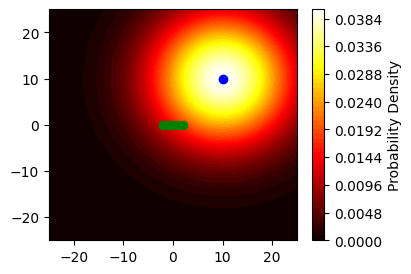

In [13]:
#Spawn Drones and move to initial position

# Create the swarm object by passing the name
# of the world from the .sdf world file.
swarm = Swarm("rhea_swarm")

# Spawn X drones and keep the returning ids as handles
ids = swarm.spawn(NUM_DRONES)

#Create Fake Person Location
person_waypoint =np.array([5,5])

# First waypoints
waypoints = np.empty((0,3),float)
for i in range (NUM_DRONES):
    waypoints= np.append(waypoints,np.array([[math.ceil(i-(NUM_DRONES/2)),0.0,DRONE_HEIGHT]]), axis=0)

#create Initial
swarm.waypoints(ids, waypoints)

#Initialize Target Position
Target_Position = [10,10]

Last_Known_Position = Target_Position

#Visibility by Coordiantes File:
grid_visibility = np.full((AREA_SIZE_X,AREA_SIZE_Y), INITIAL_VISIBILITY)

#Create Target Probability Grid
x = np.linspace(-grid_offset, grid_offset, GRID_SIZE)
y = np.linspace(-grid_offset, grid_offset, GRID_SIZE)
x, y = np.meshgrid(x, y)

sigma= 10

prob_density = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-((x - Last_Known_Position[0])**2 + (y - Last_Known_Position[1])**2) / (2 * sigma**2))


import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.contourf(x, y, prob_density, levels=50, cmap='hot')
plt.colorbar(label='Probability Density')
plt.scatter([Last_Known_Position[0]], [Last_Known_Position[1]], color='blue', label='Last Known Position')
plt.scatter([waypoints[:,0]], [waypoints[:,1]], color='green', label='Drones')
plt.show()



In [9]:
#print(swarm.depth_images[1])
print(check_ground_visibility(swarm.depth_images[1]))


0.7130775451660156


In [10]:
# Problem classes
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.problems.functional import FunctionalProblem
from pymoo.optimize import minimize

# Algorithmss
from pymoode.algorithms import DE, GDE3, NSDE, NSDER
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

# Reference directions and test problems
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

# Survival operators
from pymoode.survival import RankAndCrowding, ConstrRankAndCrowding

# Termination
from pymoo.termination.default import DefaultSingleObjectiveTermination, DefaultMultiObjectiveTermination

# Performance
from pymoode.performance import SpacingIndicator


In [11]:
class MyProblem(Problem):

    def __init__(self, grid_size, n_drones, n_steps, grid_visibility, target_probabilities):
        
        self.grid_size = grid_size
        self.n_drones = n_drones
        n_var=2*n_drones
        #TODO Schrittweite als Var
        self.n_steps = n_steps
        self.grid_visibility = grid_visibility
        self.target_probabilities = target_probabilities

        super().__init__(
            n_var=n_var,  # Variables in the solutions (x,y)
            n_obj=2,      # Number of Objectives we wanna optimize
            n_constr=0,   # No additional constraints, TODO: add no crashing into eachother
            xl=-2.0,      # Lower boundaries of solution variables
            xu=2.0,       # Upper bounds of solution vars
            vtype=int)    

        #x are the waypoints
    def _evaluate(self, x, out, *args, **kwargs):
        
        #reshapes the variables back into a waypoint array
        coordinates = x.reshape(-1, 2)
               
        summed_probability,summed_visibility = 0,0
        
        for waypoint in coordinates:
            x_cord= waypoint[0] + grid_offset
            y_cord= waypoint[1] + grid_offset
            
            summed_probability += prob_density[x_cord][y_cord]
            
            #TODO: nur gemeinsamer Boden
            summed_visibility  += grid_visibility[x_cord][y_cord]
        
        
        out["F"] = np.column_stack([-summed_visibility, -summed_probability])


# Define the problem
problem = MyProblem(GRID_SIZE, NUM_DRONES, NUM_GENERATIONS, grid_visibility, prob_density)

# Define the algorithm
algorithm = DE(
    pop_size=50,
    sampling="real_random",    #Für initiale Population
    variant="DE/rand/1/bin",
    crossover=crossover,
    mutation=mutate,
    #wieviel schritte in zukunft
)





In [ ]:
#termination = get_termination("n_gen", 200)

result = minimize(
    problem,
    algorithm, 
    #termination, 
    seed=1, 
    save_history=True, 
    verbose=True)

#best_solution = result.X[np.argmin(result.F[:, 0] + result.F[:, 1])]

[0, -5.0] [4, 5.0]


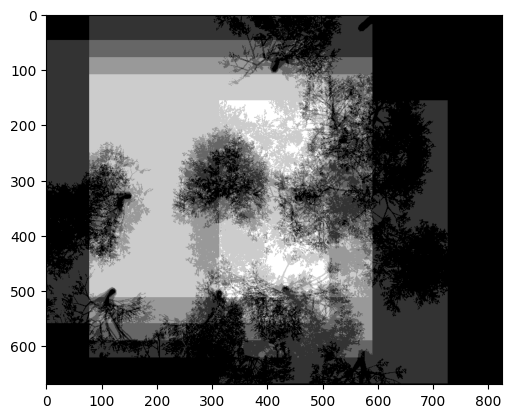

UnboundLocalError: local variable 'Target_Position' referenced before assignment

In [33]:
finished=False
#Drone waypoints got from -25 to 25, Array from 0 to 50
waypoints=np.array([[-5,0,35.],[-2,-5,35.],[ 0,0,35.],[ 2,0,35.],[5,15,35.]])
swarm.waypoints(ids,waypoints)

while not finished:
    #wait until all drones recieved
    if swarm.received_frames[ids[-1]]:
        test = getOverlapArray(waypoints)        
        
        import matplotlib.pyplot as plt 
        plt.imshow(test, cmap='gray') 
        plt.show()
                

        #Find new best waypoints
        #best_solution = result.X
        #best_fitness = result.F
        #print("Best Solution: {} \n with a Score of {}".format(best_solution,best_fitness))
        
        #Move Drones to best waypoints
        #current_waypoints = best_solution
        #swarm.waypoints(ids, current_waypoints)
        
        #Update Target Model:
        sigma=sigma+0.5
        prob_density = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-((x - Last_Known_Position[0])**2 + (y - Last_Known_Position[1])**2) / (2 * sigma**2))
        
        #Move Target-Person
        update_Target_Position()
        print("Moving Target to {}".format(Target_Position))
                       
        
        plt.figure(figsize=(4, 3))
        plt.contourf(x, y, prob_density, levels=50, cmap='hot')
        plt.colorbar(label='Probability Density')
        plt.scatter([Target_Position[0]], [Target_Position[1]], color='blue', label='Target Position')
        plt.scatter([waypoints[:,0]], [waypoints[:,1]], color='green', label='Drones')
        plt.show()
                       
        #if StopCondition:
            #finished=True

In [ ]:
print(grid_visibility)
current_waypoints = waypoints
for d_z in range(0, 30):

    # Set the waypoints for all drones
    current_waypoints = current_waypoints + [[2,0,0],[0,2,0],[0,0,0]]
    
    swarm.waypoints(ids, current_waypoints)
    # Wait until the data has arrived
    time_delta = 0.01           # Delta time per sleep command in seconds
    time_passed = 0.0           # Time counter to keep track of the time in seconds
    timeout = 10.0               # Timeout in case something goes wrong

    timeout_occured = False

    while time_passed < timeout:
        # All frames for a waypoint called send
        # together, so it is enough to check the
        # last one.
        if swarm.received_frames[ids[-1]]:
            print("All frames recieved")
            print (current_waypoints)
            print("depth image for ID={}:".format(1))
            d_i = swarm.depth_images[1]
            print(np.shape(d_i))
            #for i in range(len(d_i)):
            #    print(d_i[i])
            
            for id in ids:
                rgb_image = swarm.rgb_images[id]
                #thermal_image = swarm.thermal_images[id]
                depth_image = swarm.depth_images[id]
                # In this example we only store them in a data directory
                # OpenCV expects BGR but it is RGB, so switch the channels
                #cv2.imwrite(f"../../data/swarm/rgb_image_drone_{id}_dz_{d_z}.png", cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))    
                #cv2.imwrite(f"../../data/swarm/thermal_image_drone_{id}_dz_{d_z}.png", thermal_image)
                #cv2.imwrite(f"../../data/swarm/depth_image_drone_{id}_dz_{d_z}.png", depth_image)
                drone_waypoint=waypoints[id]
                vis = check_ground_visibility(swarm.depth_images[id])
            
                x_cord=int(drone_waypoint[0]+grid_offset)
                y_cord=int(drone_waypoint[1]+grid_offset)
                print(vis)
                grid_visibility[x_cord][y_cord]=vis
            
            
            plt.figure(figsize=(4, 3))
            plt.contourf(x, y, grid_visibility, levels=50, cmap='hot')
            plt.colorbar(label='Visibility')
            plt.show()
            break
        time.sleep(time_delta)
        time_passed += time_delta
    if time_passed >= timeout:
            timeout_occured = True
            print(f"Timeout reached for waypoints with dz={d_z}")

if timeout_occured:
    raise TimeoutError("Timeout occured while waiting for waypoint")
    
print("Finished")